## Project description

In this project I will explore the dataset 'Plant Data Set', and intuitively enough this dataset is about plants.
Data has been extracted from the USDA plants database. It contains all plants in the database and the states of USA and Canada (in addition to Greenland and St. Pierre and Miquelon) where they occur. Originally each row includes name of the plant followed by a list of state abbreviations where it is found.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.clustering import KMeans
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, Row, IntegerType
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sch
import seaborn as sns
from tqdm.notebook import tqdm

### Dataset abbreviations are found [here](https://archive.ics.uci.edu/ml/machine-learning-databases/plants/stateabbr.txt)

To see connections between countries in addition to states I seperated the states into different lists based on country. It may be difficult to draw any conclusions since the number of states is highly unbalanced.

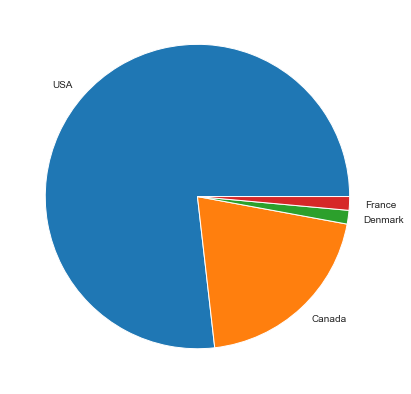

In [2]:
us_states = ['ab', 'ak', 'ar', 'az', 'ca', 'co', 'ct', 'de', 'dc', 'fl', 'ga', 'hi', 'id', 'il', 'in', 'ia',
             'ks', 'ky', 'la', 'me', 'md', 'ma', 'mi', 'mn', 'ms', 'mo', 'mt', 'ne', 'nv', 'nh', 'nj', 'nm',
             'ny', 'nc', 'nd', 'oh', 'ok', 'or', 'pa', 'pr', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'vt', 'va',
             'vi', 'wa', 'wv', 'wi',
            'wy']

canada_states = ['al', 'bc', 'mb', 'nb', 'lb', 'nf', 'nt', 'ns', 'nu', 'on', 'pe', 'qc',
                 'sk', 'yt',]

denmark_state = ['dengl'] # Greenland

france_state = ['fraspm'] # St. Pierre and Miquelon


# Countries in dataset
countries = ['USA', 'Canada', 'Denmark',
        'France']

num_states = [len(us_states), len(canada_states), len(denmark_state), len(france_state)]

# Creating Pie chart based on states in each country
plt.figure(figsize =(10, 7))
plt.pie(num_states, labels = countries)

plt.show()

### Importing dataset
Dataset was downloaded from [Plant Data Set on uci](https://archive.ics.uci.edu/ml/machine-learning-databases/plants/plants.data) and placed in project root directory.

##

#### The data rows follow a pattern:

Name,list of states where it exists

abelia,fl,nc
abelia x grandiflora,fl,nc
abelmoschus,ct,dc,fl,hi,il,ky,la,md,mi,ms,nc,sc,va,pr,vi
abelmoschus esculentus,ct,dc,fl,il,ky,la,md,mi,ms,nc,sc,va,pr,vi
abelmoschus moschatus,hi,pr

To convert this into a usable dataframe I am going to set columns to name and all states and an integer 1 or 0 based on the plant occur in the state

In [3]:
# Start a Spark session
spark = SparkSession.builder.appName("CreateDF").getOrCreate()

# Path to dataset
url = 'plants.data'

state_abbreviations =  us_states + canada_states + denmark_state + france_state
features = ['name'] + state_abbreviations

# Read the CSV file into a RDD
rdd = spark.sparkContext.textFile(url)

# Define the schema for the DataFrame by extracting the unique features from the RDD
schema = StructType([StructField(features[0], StringType(), False)] +
                    [StructField(feature, IntegerType(), True) for feature in features[1:]])

# This generates a row from name + abbreviation list in the data
def gen_row(row):
    vals = row.split(',')

    # Vals[0] = name
    return Row(*(vals[0],) + tuple(1 if feature in vals else 0 for feature in features[1:]))


# Create the DataFrame from the RDD and schema
df = spark.createDataFrame(rdd.map(gen_row, schema), schema=schema)

# Show the first 15 columns and 5 first rows of the DataFrame
df.select(df.columns[:15]).show(5, False)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/13 21:22:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/02/13 21:22:43 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|name                  |ab |ak |ar |az |ca |co |ct |de |dc |fl |ga |hi |id |il |
+----------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|abelia                |0  |0  |0  |0  |0  |0  |0  |0  |0  |1  |0  |0  |0  |0  |
|abelia x grandiflora  |0  |0  |0  |0  |0  |0  |0  |0  |0  |1  |0  |0  |0  |0  |
|abelmoschus           |0  |0  |0  |0  |0  |0  |1  |0  |1  |1  |0  |1  |0  |1  |
|abelmoschus esculentus|0  |0  |0  |0  |0  |0  |1  |0  |1  |1  |0  |0  |0  |1  |
|abelmoschus moschatus |0  |0  |0  |0  |0  |0  |0  |0  |0  |0  |0  |1  |0  |0  |
+----------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
only showing top 5 rows



### Visualizing dataset
Show first 100 rows and the state abbreviations present for each as a binary image

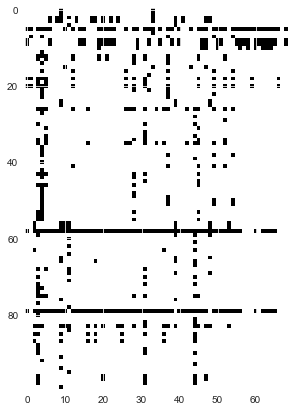

In [4]:
# Convert the DataFrame to a numpy array
first_100 = df.select(features[1:]).take(100)

# Plot binary matrix
plt.figure(figsize =(10, 7))
plt.imshow(first_100, cmap='binary')
plt.show()

### Creating a correlation matrix between states

23/02/13 21:22:50 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/02/13 21:22:50 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/02/13 21:22:50 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


<AxesSubplot: >

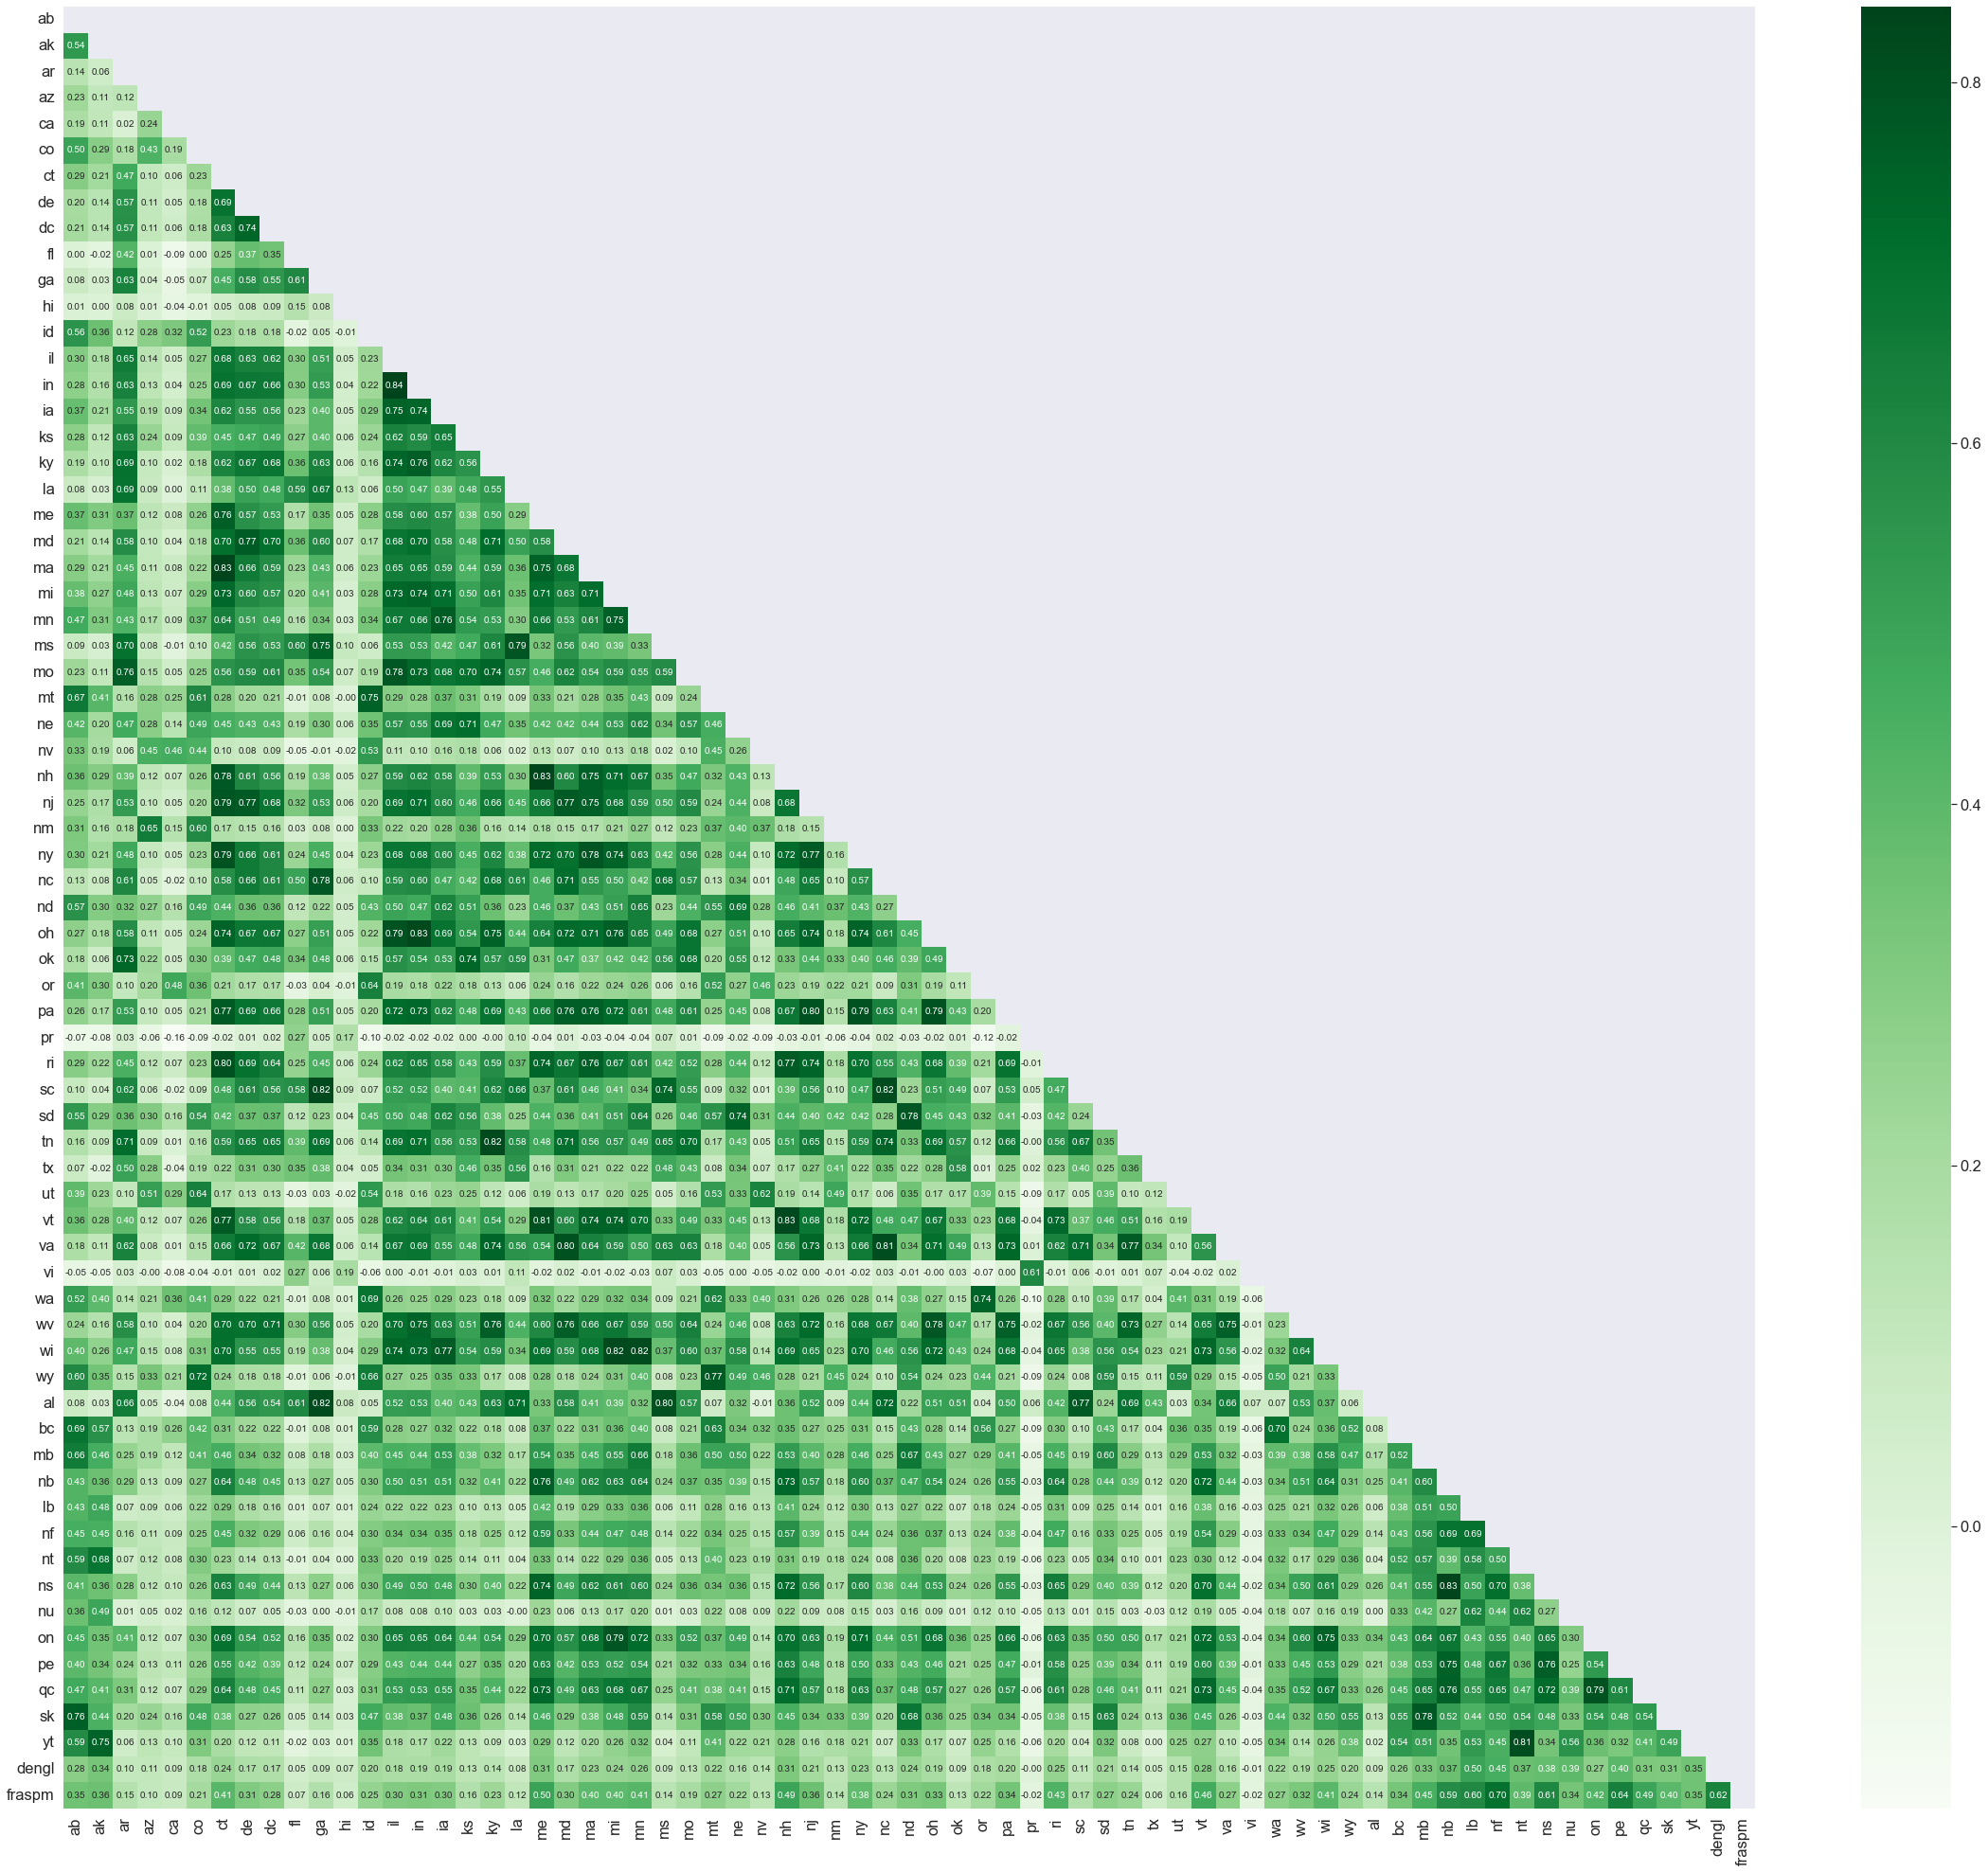

In [5]:
# Convert to vector column first
vector_col = "corr_vector"
assembler = VectorAssembler(inputCols=df.columns[1:], outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)


matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corr_matrix = matrix.toArray().tolist()
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns=state_abbreviations)

sns.set(font_scale=1.5)

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(40,35))
sns.heatmap(corr_matrix_df,
            mask=mask,
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values,  cmap="Greens", annot=True, fmt=".2f", annot_kws={"size": 10})

### KMeans clustering

In [6]:
# Select the features to use for clustering
df_cluster = df.select(features[1:])

# Extract features for clustering (all columns except the first, which is the name of the plant)
assembler = VectorAssembler(inputCols=df.columns[1:], outputCol="features")
df_clustering = assembler.transform(df)

sum_squared_dist = []
K = range(2, len(state_abbreviations) + 1)
for k in tqdm(K):
    # Train a KMeans model with the k number of clusters
    kmeans = KMeans(k=k, seed=1)
    model = kmeans.fit(df_clustering)

    sum_squared_dist.append(model.summary.trainingCost)

  0%|          | 0/68 [00:00<?, ?it/s]

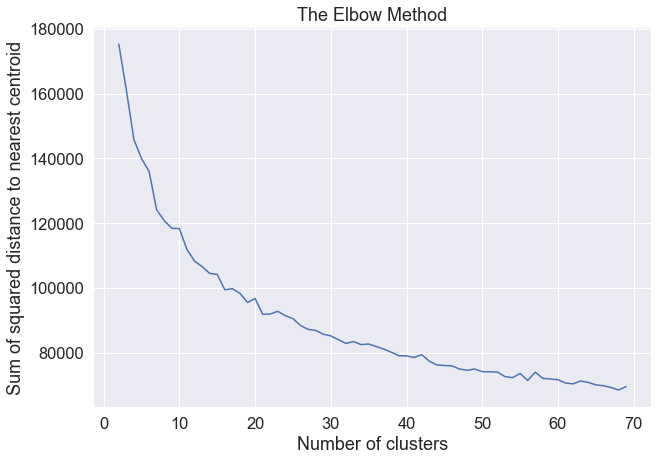

In [7]:
plt.figure(figsize =(10, 7))
plt.plot(K, sum_squared_dist)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distance to nearest centroid')
plt.show()

Based on the plot we select k to be ...

In [8]:
optimal_clusters = 16

kmeans = KMeans(k=optimal_clusters, seed=1)
model = kmeans.fit(df_clustering)

# Predict the cluster for data point
predictions = model.transform(df_clustering)

# Show the resulting clusters
predictions.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|        12|  616|
|         1|  612|
|        13| 1673|
|         6|  720|
|         3| 2079|
|         5| 1067|
|        15|  656|
|         9|  616|
|         4| 1996|
|         8| 8219|
|         7| 1115|
|        10| 1876|
|        11| 6265|
|        14|  561|
|         2| 1078|
|         0| 5632|
+----------+-----+



23/02/13 21:26:09 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/02/13 21:26:09 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


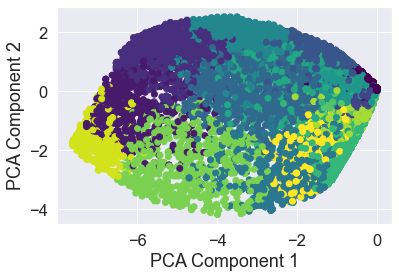

In [9]:
pca = PCA(k=3, inputCol="features")
pca.setOutputCol("pca_features")
model = pca.fit(predictions)

# Get the PCA features
pca_features = model.transform(predictions)
pca_features = pca_features.select("pca_features")


# Convert the PCA features to a numpy array
pca_np = np.array([x.__getitem__("pca_features") for x in pca_features.collect()])

# Plot the first two principal components
plt.scatter(pca_np[:, 0], pca_np[:, 1], c=predictions.select('prediction').collect(), cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

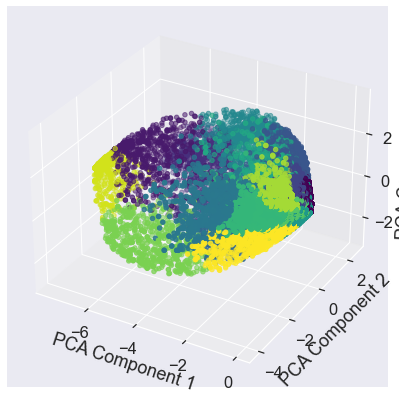

In [10]:
# To rotate plot use command below
# %matplotlib notebook

# Plot the first three principal components in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(projection='3d')
ax.scatter(pca_np[:, 0], pca_np[:, 1], pca_np[:, 2], c=predictions.select('prediction').collect(), cmap='viridis')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.show()

### Hierarchical clustering


In [11]:
# Calculate pairwise Jaccard distances between states

print(df.select(df.columns[1:]).take(2))
#dist = spd.pdist(df.select(df.columns[1:]).collect(), metric='jaccard')

# Perform hierarchical clustering
Z = sch.linkage(dist, method='ward')

# Plot the dendrogram
plt.figure(figsize=(32, 32))
sch.dendrogram(Z)
plt.show()

# Calculate pairwise Jaccard distances between states
dist = spd.pdist(array, metric='jaccard')

# Convert the distances to a distance matrix
dist_matrix = spd.squareform(dist)

# Convert the distance matrix to a pandas dataframe
df_dist = pd.DataFrame(dist_matrix, index=df['name'], columns=df['name'])

# Plot the heatmap
sns.heatmap(df_dist)
plt.show()


[Row(ab=0, ak=0, ar=0, az=0, ca=0, co=0, ct=0, de=0, dc=0, fl=1, ga=0, hi=0, id=0, il=0, in=0, ia=0, ks=0, ky=0, la=0, me=0, md=0, ma=0, mi=0, mn=0, ms=0, mo=0, mt=0, ne=0, nv=0, nh=0, nj=0, nm=0, ny=0, nc=1, nd=0, oh=0, ok=0, or=0, pa=0, pr=0, ri=0, sc=0, sd=0, tn=0, tx=0, ut=0, vt=0, va=0, vi=0, wa=0, wv=0, wi=0, wy=0, al=0, bc=0, mb=0, nb=0, lb=0, nf=0, nt=0, ns=0, nu=0, on=0, pe=0, qc=0, sk=0, yt=0, dengl=0, fraspm=0), Row(ab=0, ak=0, ar=0, az=0, ca=0, co=0, ct=0, de=0, dc=0, fl=1, ga=0, hi=0, id=0, il=0, in=0, ia=0, ks=0, ky=0, la=0, me=0, md=0, ma=0, mi=0, mn=0, ms=0, mo=0, mt=0, ne=0, nv=0, nh=0, nj=0, nm=0, ny=0, nc=1, nd=0, oh=0, ok=0, or=0, pa=0, pr=0, ri=0, sc=0, sd=0, tn=0, tx=0, ut=0, vt=0, va=0, vi=0, wa=0, wv=0, wi=0, wy=0, al=0, bc=0, mb=0, nb=0, lb=0, nf=0, nt=0, ns=0, nu=0, on=0, pe=0, qc=0, sk=0, yt=0, dengl=0, fraspm=0)]


NameError: name 'dist' is not defined